In [1]:
# Importing Libraries
import re
import nltk
import string
import numpy as np
import contractions
import pandas as pd
import tensorflow as tf
from termcolor import colored
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Importing train and test datasets
train_data = pd.read_csv(r'train.csv', engine='python', encoding='utf-8')
test_data = pd.read_csv(r'test.csv', engine='python', encoding='utf-8')

In [3]:
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
# Rename the 'Class Index' columns
train_data = train_data.rename(columns = {'Class Index': 'Class_Index'}, inplace = False)
test_data = test_data.rename(columns = {'Class Index': 'Class_Index'}, inplace = False)

In [5]:
# Calculate the index values
train_data['Class_Index'].value_counts() , test_data['Class_Index'].value_counts()

(3    30000
 4    30000
 2    30000
 1    30000
 Name: Class_Index, dtype: int64,
 3    1900
 4    1900
 2    1900
 1    1900
 Name: Class_Index, dtype: int64)

In [6]:
# Define a function for text cleaning
def clean(text):
    # convert text to lowercase
    text = text.lower()  
    # git red of non word carachters
    text = re.sub(r'\W', ' ', text)
    # remove digits
#     text = re.sub(r'\d', ' ', text)
    # remove single carachters
    text = re.sub(r'\s+[a-z]\s+', ' ', text, flags=re.I)
    # remove single carachters at the start of the sentence 
    text = re.sub(r'^[a-z]\s+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'^\s', '', text) # space at beggining
    text = re.sub(r'\s$', '', text) # space at ending
    # Removing contractions "abbreviations"
    text = contractions.fix(text)
    # get rid of stopwords
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    # get rid of any word which is not in English dictionary
    # text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    # # Stemming words
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    # Lemmatizing words
    # lemmatizer = WordNetLemmatizer()
    # text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [7]:
# Apply the clean function
train_data["Description"] = train_data["Description"].apply(clean)
test_data["Description"] = test_data["Description"].apply(clean)

In [8]:
train_data.head()

,Class_Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),reuter short seller wall street dwindl band ul...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,reuter privat invest firm carlyl group reput m...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),reuter soar crude price plu worri economi outl...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,reuter author halt oil export flow main pipeli...
4,3,"Oil prices soar to all-time record, posing new...",afp tearaway world oil price toppl record stra...


In [9]:
# Define training, testing data, and maximum length
X_train = train_data["Description"] 
X_test = test_data["Description"] 
length_max = X_train.map(lambda x: len(x.split())).max()
length_max

137

In [10]:
# Define training and testing labels
y_train = train_data['Class_Index'].apply(lambda x: x-1).values
y_test = test_data['Class_Index'].apply(lambda x: x-1).values

In [11]:
# Splitting the training data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
# Define the vocabularies size, embedding size
vocabularies = 30000 
embeddings = 40
# Define the tokenizer
tokenizer = Tokenizer(num_words=vocabularies)
tokenizer.fit_on_texts(X_train.values)
# Tokenizing and Padding data
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=length_max)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=length_max)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=length_max)

In [67]:
# Build the model 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocabularies, output_dim=100, mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1), 
    tf.keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [68]:
class myCallback(tf.keras.callbacks.Callback):
    def epoch(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            self.model.stop_training = True
            print("\nThe accuracy has reached > 95%!")
callbacks = myCallback()

In [69]:
# Compile the model
model.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
# Fit the model
history = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_val, y_val), verbose=1,
                         callbacks=[callbacks], validation_steps=5, steps_per_epoch=25)

Epoch 1/5
25/25 [==============================] - 35s 1s/step - loss: 1.3309 - accuracy: 0.3928 - val_loss: 1.0114 - val_accuracy: 0.5828
Epoch 2/5
25/25 [==============================] - 29s 1s/step - loss: 0.7794 - accuracy: 0.6884 - val_loss: 0.5637 - val_accuracy: 0.8172
Epoch 3/5
25/25 [==============================] - 29s 1s/step - loss: 0.4371 - accuracy: 0.8459 - val_loss: 0.4152 - val_accuracy: 0.8609
Epoch 4/5
25/25 [==============================] - 30s 1s/step - loss: 0.4075 - accuracy: 0.8594 - val_loss: 0.3909 - val_accuracy: 0.8766
Epoch 5/5
25/25 [==============================] - 31s 1s/step - loss: 0.3631 - accuracy: 0.8784 - val_loss: 0.3710 - val_accuracy: 0.8797


In [70]:
print('Training Accuracy')
accuracy=model.evaluate(X_train,y_train)
print('Loss: {} \nAccuracy: {}'.format(accuracy[0],accuracy[1]))

Training Accuracy
3000/3000 [==============================] - 364s 121ms/step - loss: 0.3358 - accuracy: 0.8881
Loss: 0.335815966129303 
Accuracy: 0.8881354331970215


In [71]:
print('Validation Accuracy')
accuracy=model.evaluate(X_val,y_val)
print('Loss: {} \nAccuracy: {}'.format(accuracy[0],accuracy[1]))

Validation Accuracy
750/750 [==============================] - 106s 141ms/step - loss: 0.3615 - accuracy: 0.8792
Loss: 0.36149048805236816 
Accuracy: 0.8791666626930237


In [72]:
print('Test Accuracy')
accuracy=model.evaluate(X_test,y_test)
print('Loss: {} \nAccuracy: {}'.format(accuracy[0],accuracy[1]))

Test Accuracy
238/238 [==============================] - 31s 128ms/step - loss: 0.3734 - accuracy: 0.8763
Loss: 0.373414009809494 
Accuracy: 0.8763157725334167


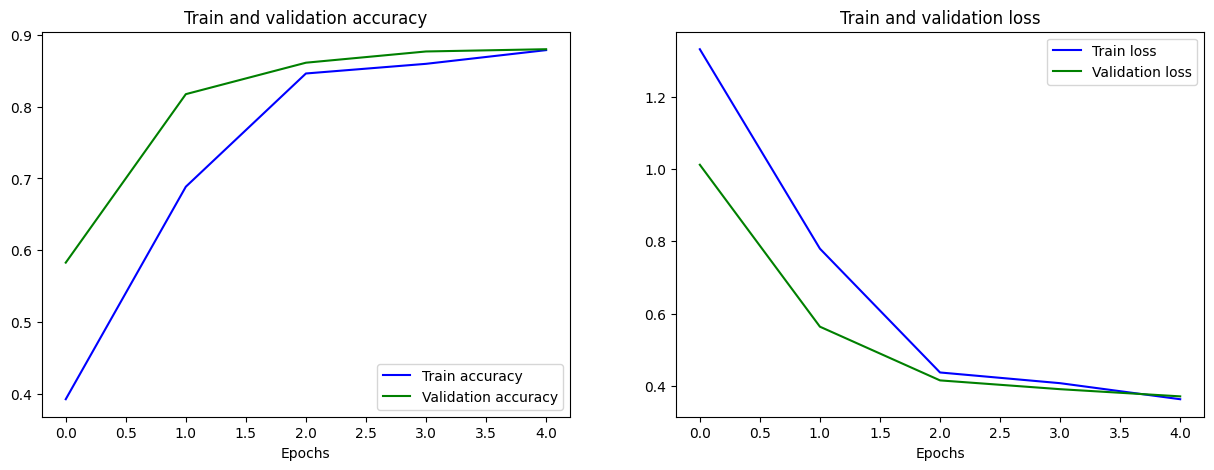

In [73]:
# Plot training and validation loss and accuracy
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, 'b', label='Train accuracy')
    plt.plot(val_acc, 'g', label='Validation accuracy')
    plt.title('Train and validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(loss, 'b', label='Train loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title('Train and validation loss')
    plt.xlabel("Epochs")
    plt.legend()
    
plot_history(history)

In [74]:
# Save model for later usage
model.save('model.hdf5')

In [75]:
# Define a function to predict new texts
def predict(text):
    labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
    seq = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=length_max)
    preds = [labels[np.argmax(i)] for i in model.predict(seq)]
    for news, label in zip(text, preds):
        print('{} - {}'.format(colored(news, 'blue'), colored(label, 'green')))

In [76]:
predict(["These 6 Club stocks look reasonably priced as Wall Street shuns high flyers"])

1/1 [==============================] - 2s 2s/step
These 6 Club stocks look reasonably priced as Wall Street shuns high flyers - Sports News


In [77]:
predict(["Russian President Vladimir Putin had proposed a 36-hour truce to mark Russian Orthodox Christmas, but Kyiv dismissed it as a ploy."])

1/1 [==============================] - 0s 105ms/step
Russian President Vladimir Putin had proposed a 36-hour truce to mark Russian Orthodox Christmas, but Kyiv dismissed it as a ploy. - World News


In [78]:
predict(["In the future all machines, from milling machines to welding robots, will be networked with one another, according to German research organization Fraunhofer. "])

1/1 [==============================] - 0s 97ms/step
In the future all machines, from milling machines to welding robots, will be networked with one another, according to German research organization Fraunhofer.  - World News


In [79]:
predict(["Saudi Arabian club Al Nassr have denied reports that Cristiano Ronaldo has a clause in his contract where the Portugal forward is to serve as an ambassador for the Gulf country's 2030 World Cup bid."])

1/1 [==============================] - 0s 104ms/step
Saudi Arabian club Al Nassr have denied reports that Cristiano Ronaldo has a clause in his contract where the Portugal forward is to serve as an ambassador for the Gulf country's 2030 World Cup bid. - Sports News


238/238 [==============================] - 28s 118ms/step


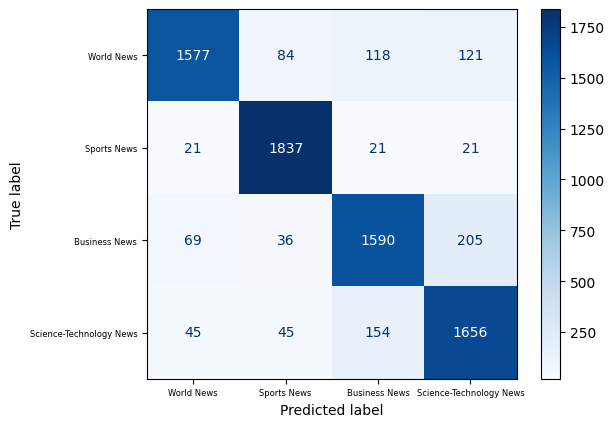

In [80]:
# Plotting confusion matrix for Test set
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(X_test)]
cm  = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot(cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=6)
plt.yticks(range(4), labels, fontsize=6)
plt.show()

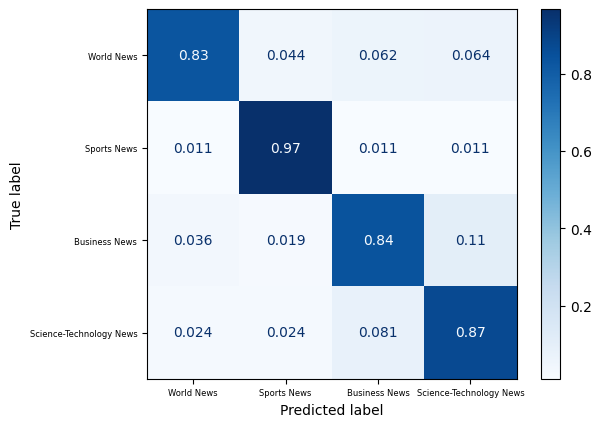

In [81]:
cm  = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels).plot(cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=6)
plt.yticks(range(4), labels, fontsize=6)
plt.show()

In [82]:
print('Classification Report for Test set')
print(classification_report(y_test, preds))

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1900
           1       0.92      0.97      0.94      1900
           2       0.84      0.84      0.84      1900
           3       0.83      0.87      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

